In [16]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [17]:
!python --version

Python 3.10.11


In [18]:
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam

In [19]:

def define_discriminator(image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model


In [20]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [21]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g


In [22]:
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

In [23]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [24]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [25]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [26]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


In [27]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

#**IMPLEMENTATION**

In [28]:

from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np


In [29]:
'''
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]
    '''

'\ndef load_images(path, size=(256,512)):\n\tsrc_list, tar_list = list(), list()\n\t# enumerate filenames in directory, assume all are images\n\tfor filename in listdir(path):\n\t\t# load and resize the image\n\t\tpixels = load_img(path + filename, target_size=size)\n\t\t# convert to numpy array\n\t\tpixels = img_to_array(pixels)\n\t\t# split into satellite and map\n\t\tsat_img, map_img = pixels[:, :256], pixels[:, 256:]\n\t\tsrc_list.append(sat_img)\n\t\ttar_list.append(map_img)\n\treturn [asarray(src_list), asarray(tar_list)]\n    '

In [30]:
def load_images(path, size=(256,256)):
    src_list, tar_list = list(), list()
    src_path = path + "Flash/"
    tar_path = path + "Ambient/"
    src_filenames = sorted(list(set(listdir(src_path)) - {'desktop.ini', 'whatever.ini'}), key=str.lower)
    tar_filenames = sorted(list(set(listdir(tar_path)) - {'desktop.ini', 'whatever.ini'}), key=str.lower)
    #print(src_filenames)
    #print(tar_filenames)
    for filename in src_filenames:
        
        pixels = load_img(src_path + filename, target_size=size)
        pixels = img_to_array(pixels)
        src_list.append(pixels)
    for filename in tar_filenames:
        pixels = load_img(tar_path + filename, target_size=size)
        pixels = img_to_array(pixels)
        tar_list.append(pixels)
    
    return [asarray(src_list), asarray(tar_list)]

In [31]:
# dataset path
path = 'C:/Users/archi/Desktop/Images/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (333, 256, 256, 3) (333, 256, 256, 3)


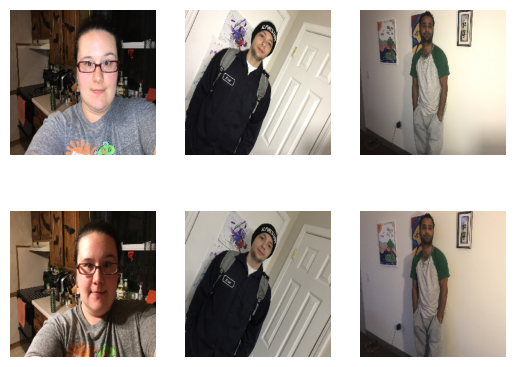

In [32]:

n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [33]:
from keras.layers import MaxPooling2D,Conv2D,Input,Add,MaxPool2D,Flatten,AveragePooling2D,Dense,BatchNormalization,ZeroPadding2D,Activation,Concatenate,UpSampling2D
from keras.models import Model


In [34]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
from keras import backend as K
from keras import activations, initializers, regularizers, constraints, metrics
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)
#from tensorflow.keras.utils import conv_utils, multi_gpu_model
from keras.layers import Lambda
#from keras.engine import Layer, InputSpec
#from keras.legacy import interfaces

In [35]:
# import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

C:\Users\archi\Anaconda3\envs\prism-env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [36]:
data = [src_images, tar_images]


In [37]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [38]:
dataset = preprocess_data(data)


In [83]:
from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1)  
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()       
#Execution time of the model 
execution_time = stop1-start1                
print("Execution time is: ", execution_time)

1/1 [==============================] - 1s 948ms/step
>1, d1[0.326] d2[1.064] g[53.827]
1/1 [==============================] - 0s 193ms/step
>2, d1[0.439] d2[0.841] g[66.592]
1/1 [==============================] - 0s 208ms/step
>3, d1[0.522] d2[0.723] g[36.839]
1/1 [==============================] - 0s 223ms/step
>4, d1[0.529] d2[0.603] g[54.450]
1/1 [==============================] - 0s 199ms/step
>5, d1[0.385] d2[0.630] g[43.261]
1/1 [==============================] - 0s 190ms/step
>6, d1[0.467] d2[0.535] g[37.739]
1/1 [==============================] - 0s 190ms/step
>7, d1[0.402] d2[0.536] g[41.783]
1/1 [==============================] - 0s 189ms/step
>8, d1[0.378] d2[0.445] g[38.416]
1/1 [==============================] - 0s 209ms/step
>9, d1[0.460] d2[0.422] g[25.281]
1/1 [==============================] - 0s 189ms/step
>10, d1[0.414] d2[0.528] g[40.991]
1/1 [==============================] - 0s 175ms/step
>11, d1[0.442] d2[0.478] g[29.952]
1/1 [==============================] - 0s

1/1 [==============================] - 0s 156ms/step
>186, d1[0.317] d2[0.330] g[50.920]
1/1 [==============================] - 0s 166ms/step
>187, d1[0.276] d2[0.256] g[31.688]
1/1 [==============================] - 0s 156ms/step
>188, d1[0.392] d2[0.442] g[31.458]
1/1 [==============================] - 0s 187ms/step
>189, d1[0.317] d2[0.326] g[23.374]
1/1 [==============================] - 0s 203ms/step
>190, d1[0.385] d2[0.337] g[29.770]
1/1 [==============================] - 0s 195ms/step
>191, d1[0.205] d2[0.613] g[43.519]
1/1 [==============================] - 0s 186ms/step
>192, d1[0.337] d2[0.293] g[51.215]
1/1 [==============================] - 0s 189ms/step
>193, d1[0.516] d2[0.318] g[26.263]
1/1 [==============================] - 0s 197ms/step
>194, d1[0.347] d2[0.309] g[33.886]
1/1 [==============================] - 0s 188ms/step
>195, d1[0.476] d2[0.360] g[21.626]
1/1 [==============================] - 0s 198ms/step
>196, d1[0.407] d2[0.374] g[21.832]
1/1 [================

1/1 [==============================] - 0s 191ms/step
>370, d1[0.241] d2[0.124] g[40.907]
1/1 [==============================] - 0s 166ms/step
>371, d1[0.129] d2[0.240] g[27.838]
1/1 [==============================] - 0s 164ms/step
>372, d1[0.312] d2[0.297] g[32.757]
1/1 [==============================] - 0s 157ms/step
>373, d1[0.091] d2[0.110] g[31.161]
1/1 [==============================] - 0s 171ms/step
>374, d1[0.026] d2[0.097] g[27.623]
1/1 [==============================] - 0s 176ms/step
>375, d1[0.425] d2[0.909] g[18.020]
1/1 [==============================] - 0s 176ms/step
>376, d1[0.179] d2[0.158] g[31.145]
1/1 [==============================] - 0s 160ms/step
>377, d1[0.665] d2[0.252] g[19.270]
1/1 [==============================] - 0s 196ms/step
>378, d1[0.065] d2[0.157] g[40.252]
1/1 [==============================] - 0s 196ms/step
>379, d1[0.137] d2[0.125] g[15.328]
1/1 [==============================] - 0s 199ms/step
>380, d1[0.117] d2[0.835] g[21.617]
1/1 [================

1/1 [==============================] - 0s 142ms/step
>554, d1[0.112] d2[0.108] g[23.460]
1/1 [==============================] - 0s 146ms/step
>555, d1[0.889] d2[0.131] g[28.375]
1/1 [==============================] - 0s 179ms/step
>556, d1[0.150] d2[0.798] g[13.374]
1/1 [==============================] - 0s 178ms/step
>557, d1[0.576] d2[0.609] g[15.083]
1/1 [==============================] - 0s 180ms/step
>558, d1[0.193] d2[0.667] g[43.703]
1/1 [==============================] - 0s 174ms/step
>559, d1[0.564] d2[0.421] g[22.326]
1/1 [==============================] - 0s 202ms/step
>560, d1[0.478] d2[0.146] g[21.232]
1/1 [==============================] - 0s 159ms/step
>561, d1[0.551] d2[0.400] g[10.951]
1/1 [==============================] - 0s 199ms/step
>562, d1[0.037] d2[0.311] g[31.126]
1/1 [==============================] - 0s 185ms/step
>563, d1[0.243] d2[0.146] g[26.040]
1/1 [==============================] - 0s 146ms/step
>564, d1[0.513] d2[0.181] g[13.656]
1/1 [================

1/1 [==============================] - 0s 166ms/step
>738, d1[0.178] d2[0.158] g[18.455]
1/1 [==============================] - 0s 192ms/step
>739, d1[0.411] d2[0.267] g[21.499]
1/1 [==============================] - 0s 156ms/step
>740, d1[0.222] d2[0.185] g[24.153]
1/1 [==============================] - 0s 150ms/step
>741, d1[0.107] d2[0.284] g[23.037]
1/1 [==============================] - 0s 191ms/step
>742, d1[0.372] d2[0.567] g[14.783]
1/1 [==============================] - 0s 189ms/step
>743, d1[0.483] d2[0.193] g[16.254]
1/1 [==============================] - 0s 203ms/step
>744, d1[0.427] d2[0.341] g[12.608]
1/1 [==============================] - 0s 204ms/step
>745, d1[0.260] d2[0.255] g[11.612]
1/1 [==============================] - 0s 188ms/step
>746, d1[0.165] d2[0.420] g[22.437]
1/1 [==============================] - 0s 187ms/step
>747, d1[0.654] d2[0.222] g[23.284]
1/1 [==============================] - 0s 190ms/step
>748, d1[0.003] d2[0.497] g[54.078]
1/1 [================

1/1 [==============================] - 0s 156ms/step
>922, d1[0.054] d2[0.143] g[18.099]
1/1 [==============================] - 0s 147ms/step
>923, d1[0.010] d2[0.055] g[36.454]
1/1 [==============================] - 0s 151ms/step
>924, d1[0.717] d2[0.089] g[16.450]
1/1 [==============================] - 0s 206ms/step
>925, d1[0.838] d2[0.196] g[12.045]
1/1 [==============================] - 0s 189ms/step
>926, d1[0.406] d2[0.852] g[13.524]
1/1 [==============================] - 0s 184ms/step
>927, d1[0.071] d2[0.231] g[18.471]
1/1 [==============================] - 0s 190ms/step
>928, d1[0.280] d2[0.186] g[30.222]
1/1 [==============================] - 0s 185ms/step
>929, d1[0.012] d2[0.095] g[34.932]
1/1 [==============================] - 0s 172ms/step
>930, d1[0.024] d2[0.080] g[34.445]
1/1 [==============================] - 0s 189ms/step
>931, d1[0.003] d2[0.353] g[29.497]
1/1 [==============================] - 0s 188ms/step
>932, d1[0.788] d2[0.244] g[23.151]
1/1 [================

1/1 [==============================] - 0s 187ms/step
>1014, d1[0.048] d2[0.837] g[20.006]
1/1 [==============================] - 0s 186ms/step
>1015, d1[0.021] d2[0.081] g[35.846]
1/1 [==============================] - 0s 184ms/step
>1016, d1[0.006] d2[0.325] g[42.520]
1/1 [==============================] - 0s 186ms/step
>1017, d1[1.254] d2[0.090] g[14.010]
1/1 [==============================] - 0s 183ms/step
>1018, d1[0.607] d2[0.294] g[16.524]
1/1 [==============================] - 0s 186ms/step
>1019, d1[0.480] d2[0.375] g[16.498]
1/1 [==============================] - 0s 193ms/step
>1020, d1[0.466] d2[0.245] g[17.126]
1/1 [==============================] - 0s 211ms/step
>1021, d1[0.006] d2[0.131] g[40.393]
1/1 [==============================] - 0s 173ms/step
>1022, d1[0.414] d2[0.298] g[22.050]
1/1 [==============================] - 0s 158ms/step
>1023, d1[0.219] d2[0.213] g[26.457]
1/1 [==============================] - 0s 205ms/step
>1024, d1[0.281] d2[0.280] g[20.096]
1/1 [=====

1/1 [==============================] - 0s 188ms/step
>1196, d1[0.007] d2[0.247] g[34.231]
1/1 [==============================] - 0s 155ms/step
>1197, d1[0.984] d2[0.328] g[17.627]
1/1 [==============================] - 0s 192ms/step
>1198, d1[0.288] d2[0.175] g[18.764]
1/1 [==============================] - 0s 191ms/step
>1199, d1[0.143] d2[0.150] g[33.153]
1/1 [==============================] - 0s 179ms/step
>1200, d1[0.023] d2[0.160] g[23.599]
1/1 [==============================] - 0s 171ms/step
>1201, d1[0.003] d2[0.149] g[46.757]
1/1 [==============================] - 0s 195ms/step
>1202, d1[0.349] d2[0.149] g[17.615]
1/1 [==============================] - 0s 189ms/step
>1203, d1[0.005] d2[0.075] g[34.090]
1/1 [==============================] - 0s 191ms/step
>1204, d1[0.010] d2[0.102] g[33.649]
1/1 [==============================] - 0s 193ms/step
>1205, d1[1.037] d2[0.310] g[17.747]
1/1 [==============================] - 0s 180ms/step
>1206, d1[0.507] d2[0.413] g[13.887]
1/1 [=====

1/1 [==============================] - 0s 196ms/step
>1378, d1[0.063] d2[0.077] g[25.740]
1/1 [==============================] - 0s 196ms/step
>1379, d1[0.642] d2[0.157] g[17.777]
1/1 [==============================] - 0s 194ms/step
>1380, d1[0.763] d2[0.381] g[24.579]
1/1 [==============================] - 0s 178ms/step
>1381, d1[0.215] d2[0.464] g[14.451]
1/1 [==============================] - 0s 190ms/step
>1382, d1[0.368] d2[0.296] g[17.288]
1/1 [==============================] - 0s 161ms/step
>1383, d1[0.090] d2[0.264] g[24.444]
1/1 [==============================] - 0s 154ms/step
>1384, d1[0.422] d2[0.146] g[26.367]
1/1 [==============================] - 0s 169ms/step
>1385, d1[0.299] d2[0.173] g[16.986]
1/1 [==============================] - 0s 147ms/step
>1386, d1[0.002] d2[0.227] g[39.654]
1/1 [==============================] - 0s 184ms/step
>1387, d1[0.423] d2[0.395] g[12.223]
1/1 [==============================] - 0s 187ms/step
>1388, d1[0.400] d2[0.163] g[22.104]
1/1 [=====

1/1 [==============================] - 0s 189ms/step
>1560, d1[0.157] d2[0.378] g[22.982]
1/1 [==============================] - 0s 183ms/step
>1561, d1[0.003] d2[0.067] g[46.487]
1/1 [==============================] - 0s 182ms/step
>1562, d1[0.052] d2[0.170] g[18.238]
1/1 [==============================] - 0s 146ms/step
>1563, d1[0.003] d2[0.041] g[58.435]
1/1 [==============================] - 0s 149ms/step
>1564, d1[0.056] d2[0.039] g[38.887]
1/1 [==============================] - 0s 185ms/step
>1565, d1[0.010] d2[0.055] g[42.568]
1/1 [==============================] - 0s 190ms/step
>1566, d1[0.693] d2[0.063] g[26.086]
1/1 [==============================] - 0s 152ms/step
>1567, d1[0.002] d2[0.462] g[45.337]
1/1 [==============================] - 0s 152ms/step
>1568, d1[0.263] d2[0.087] g[22.032]
1/1 [==============================] - 0s 187ms/step
>1569, d1[0.183] d2[0.200] g[17.301]
1/1 [==============================] - 0s 181ms/step
>1570, d1[0.008] d2[0.208] g[29.038]
1/1 [=====

1/1 [==============================] - 0s 185ms/step
>1742, d1[0.427] d2[0.271] g[18.401]
1/1 [==============================] - 0s 149ms/step
>1743, d1[0.250] d2[0.175] g[17.731]
1/1 [==============================] - 0s 180ms/step
>1744, d1[0.009] d2[0.043] g[26.264]
1/1 [==============================] - 0s 175ms/step
>1745, d1[0.722] d2[0.610] g[13.465]
1/1 [==============================] - 0s 153ms/step
>1746, d1[0.363] d2[0.314] g[16.487]
1/1 [==============================] - 0s 186ms/step
>1747, d1[0.004] d2[0.091] g[29.468]
1/1 [==============================] - 0s 181ms/step
>1748, d1[0.009] d2[0.061] g[22.308]
1/1 [==============================] - 0s 177ms/step
>1749, d1[0.022] d2[0.055] g[37.005]
1/1 [==============================] - 0s 247ms/step
>1750, d1[0.193] d2[0.285] g[26.323]
1/1 [==============================] - 0s 181ms/step
>1751, d1[0.039] d2[0.075] g[27.411]
1/1 [==============================] - 0s 173ms/step
>1752, d1[0.257] d2[0.059] g[19.763]
1/1 [=====

1/1 [==============================] - 0s 150ms/step
>1924, d1[0.192] d2[0.795] g[13.901]
1/1 [==============================] - 0s 186ms/step
>1925, d1[0.827] d2[0.145] g[16.669]
1/1 [==============================] - 0s 148ms/step
>1926, d1[0.111] d2[0.195] g[21.505]
1/1 [==============================] - 0s 186ms/step
>1927, d1[0.889] d2[0.186] g[14.262]
1/1 [==============================] - 0s 195ms/step
>1928, d1[0.007] d2[0.131] g[26.858]
1/1 [==============================] - 0s 183ms/step
>1929, d1[0.464] d2[0.112] g[20.673]
1/1 [==============================] - 0s 181ms/step
>1930, d1[0.139] d2[0.160] g[15.791]
1/1 [==============================] - 0s 185ms/step
>1931, d1[0.528] d2[0.576] g[12.526]
1/1 [==============================] - 0s 181ms/step
>1932, d1[0.021] d2[0.317] g[20.638]
1/1 [==============================] - 0s 190ms/step
>1933, d1[0.025] d2[0.118] g[20.965]
1/1 [==============================] - 0s 203ms/step
>1934, d1[0.007] d2[0.241] g[32.803]
1/1 [=====

1/1 [==============================] - 0s 190ms/step
>2106, d1[0.038] d2[0.307] g[26.968]
1/1 [==============================] - 0s 200ms/step
>2107, d1[0.314] d2[0.216] g[16.326]
1/1 [==============================] - 0s 191ms/step
>2108, d1[0.222] d2[0.067] g[18.015]
1/1 [==============================] - 0s 196ms/step
>2109, d1[0.004] d2[0.553] g[31.828]
1/1 [==============================] - 0s 194ms/step
>2110, d1[0.609] d2[0.162] g[13.350]
1/1 [==============================] - 0s 200ms/step
>2111, d1[0.003] d2[1.013] g[25.291]
1/1 [==============================] - 0s 152ms/step
>2112, d1[0.661] d2[0.108] g[15.629]
1/1 [==============================] - 0s 200ms/step
>2113, d1[0.010] d2[0.108] g[31.387]
1/1 [==============================] - 0s 201ms/step
>2114, d1[0.398] d2[0.221] g[14.933]
1/1 [==============================] - 0s 216ms/step
>2115, d1[0.143] d2[0.884] g[15.416]
1/1 [==============================] - 0s 200ms/step
>2116, d1[0.106] d2[0.137] g[17.380]
1/1 [=====

1/1 [==============================] - 0s 160ms/step
>2288, d1[0.712] d2[0.207] g[13.248]
1/1 [==============================] - 0s 195ms/step
>2289, d1[0.457] d2[0.459] g[22.014]
1/1 [==============================] - 0s 190ms/step
>2290, d1[0.152] d2[0.460] g[17.673]
1/1 [==============================] - 0s 160ms/step
>2291, d1[0.266] d2[0.157] g[19.681]
1/1 [==============================] - 0s 200ms/step
>2292, d1[0.013] d2[0.080] g[28.099]
1/1 [==============================] - 0s 200ms/step
>2293, d1[0.681] d2[0.125] g[19.010]
1/1 [==============================] - 0s 201ms/step
>2294, d1[0.004] d2[0.094] g[42.267]
1/1 [==============================] - 0s 190ms/step
>2295, d1[0.020] d2[0.174] g[37.072]
1/1 [==============================] - 0s 191ms/step
>2296, d1[0.066] d2[0.140] g[17.707]
1/1 [==============================] - 0s 194ms/step
>2297, d1[0.016] d2[0.062] g[25.722]
1/1 [==============================] - 0s 160ms/step
>2298, d1[0.012] d2[0.096] g[29.582]
1/1 [=====

1/1 [==============================] - 0s 201ms/step
>2470, d1[0.984] d2[0.083] g[17.051]
1/1 [==============================] - 0s 190ms/step
>2471, d1[0.564] d2[0.206] g[17.233]
1/1 [==============================] - 0s 150ms/step
>2472, d1[0.160] d2[0.394] g[15.529]
1/1 [==============================] - 0s 200ms/step
>2473, d1[0.051] d2[0.183] g[25.817]
1/1 [==============================] - 0s 190ms/step
>2474, d1[0.006] d2[0.110] g[35.606]
1/1 [==============================] - 0s 190ms/step
>2475, d1[0.009] d2[0.244] g[30.479]
1/1 [==============================] - 0s 180ms/step
>2476, d1[0.230] d2[0.194] g[13.880]
1/1 [==============================] - 0s 200ms/step
>2477, d1[0.248] d2[0.221] g[18.861]
1/1 [==============================] - 0s 190ms/step
>2478, d1[0.060] d2[0.159] g[20.097]
1/1 [==============================] - 0s 190ms/step
>2479, d1[0.849] d2[0.185] g[15.835]
1/1 [==============================] - 0s 201ms/step
>2480, d1[0.599] d2[0.309] g[14.242]
1/1 [=====

1/1 [==============================] - 0s 194ms/step
>2652, d1[0.629] d2[0.159] g[18.580]
1/1 [==============================] - 0s 170ms/step
>2653, d1[0.463] d2[0.223] g[28.778]
1/1 [==============================] - 0s 210ms/step
>2654, d1[0.014] d2[0.313] g[28.563]
1/1 [==============================] - 0s 200ms/step
>2655, d1[0.095] d2[0.130] g[26.174]
1/1 [==============================] - 0s 190ms/step
>2656, d1[0.007] d2[0.217] g[30.086]
1/1 [==============================] - 0s 180ms/step
>2657, d1[0.451] d2[0.205] g[11.089]
1/1 [==============================] - 0s 150ms/step
>2658, d1[0.537] d2[0.164] g[15.176]
1/1 [==============================] - 0s 190ms/step
>2659, d1[0.005] d2[0.220] g[25.298]
1/1 [==============================] - 0s 194ms/step
>2660, d1[0.077] d2[0.139] g[19.831]
1/1 [==============================] - 0s 190ms/step
>2661, d1[0.025] d2[0.455] g[24.432]
1/1 [==============================] - 0s 180ms/step
>2662, d1[0.014] d2[0.084] g[31.013]
1/1 [=====

1/1 [==============================] - 0s 210ms/step
>2834, d1[0.059] d2[0.113] g[20.927]
1/1 [==============================] - 0s 161ms/step
>2835, d1[0.023] d2[0.063] g[28.179]
1/1 [==============================] - 0s 210ms/step
>2836, d1[0.160] d2[0.102] g[23.166]
1/1 [==============================] - 0s 158ms/step
>2837, d1[0.177] d2[0.256] g[19.926]
1/1 [==============================] - 0s 200ms/step
>2838, d1[0.178] d2[0.191] g[17.393]
1/1 [==============================] - 0s 200ms/step
>2839, d1[0.047] d2[0.146] g[17.619]
1/1 [==============================] - 0s 190ms/step
>2840, d1[0.210] d2[0.427] g[15.526]
1/1 [==============================] - 0s 160ms/step
>2841, d1[0.475] d2[0.311] g[17.571]
1/1 [==============================] - 0s 200ms/step
>2842, d1[0.042] d2[0.078] g[26.186]
1/1 [==============================] - 0s 199ms/step
>2843, d1[0.068] d2[0.108] g[13.369]
1/1 [==============================] - 0s 199ms/step
>2844, d1[0.007] d2[0.105] g[28.461]
1/1 [=====

1/1 [==============================] - 0s 156ms/step
>3016, d1[0.082] d2[0.048] g[29.645]
1/1 [==============================] - 0s 197ms/step
>3017, d1[0.164] d2[0.126] g[20.284]
1/1 [==============================] - 0s 194ms/step
>3018, d1[0.466] d2[0.168] g[18.338]
1/1 [==============================] - 0s 163ms/step
>3019, d1[0.685] d2[0.420] g[14.976]
1/1 [==============================] - 0s 199ms/step
>3020, d1[0.088] d2[0.168] g[22.584]
1/1 [==============================] - 0s 194ms/step
>3021, d1[0.408] d2[0.160] g[17.256]
1/1 [==============================] - 0s 192ms/step
>3022, d1[0.206] d2[0.154] g[18.841]
1/1 [==============================] - 0s 200ms/step
>3023, d1[0.007] d2[0.145] g[25.891]
1/1 [==============================] - 0s 197ms/step
>3024, d1[0.033] d2[0.381] g[22.592]
1/1 [==============================] - 0s 209ms/step
>3025, d1[0.011] d2[0.212] g[19.025]
1/1 [==============================] - 0s 191ms/step
>3026, d1[0.159] d2[0.112] g[17.351]
1/1 [=====

1/1 [==============================] - 0s 192ms/step
>3198, d1[0.281] d2[0.649] g[13.871]
1/1 [==============================] - 0s 196ms/step
>3199, d1[0.069] d2[0.139] g[30.648]
1/1 [==============================] - 0s 198ms/step
>3200, d1[0.022] d2[0.168] g[32.630]
1/1 [==============================] - 0s 157ms/step
>3201, d1[0.939] d2[0.103] g[13.907]
1/1 [==============================] - 0s 196ms/step
>3202, d1[0.047] d2[0.104] g[28.364]
1/1 [==============================] - 0s 156ms/step
>3203, d1[0.945] d2[0.169] g[26.401]
1/1 [==============================] - 0s 176ms/step
>3204, d1[0.086] d2[0.163] g[25.587]
1/1 [==============================] - 0s 210ms/step
>3205, d1[0.806] d2[0.388] g[12.767]
1/1 [==============================] - 0s 156ms/step
>3206, d1[0.334] d2[0.285] g[21.592]
1/1 [==============================] - 0s 184ms/step
>3207, d1[0.012] d2[0.105] g[28.320]
1/1 [==============================] - 0s 150ms/step
>3208, d1[0.297] d2[0.191] g[16.641]
1/1 [=====

In [39]:
from keras.models import load_model  
from numpy.random import randint  
model = load_model('model_003330.h5')  

In [40]:
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

(333, 256, 256, 3)
(256, 256, 3)
0
(1, 256, 256, 3)
1/1 [==============================] - 0s 190ms/step
(256, 256, 3)
1
(1, 256, 256, 3)
1/1 [==============================] - 0s 198ms/step
(256, 256, 3)
2
(1, 256, 256, 3)
1/1 [==============================] - 0s 203ms/step
(256, 256, 3)
3
(1, 256, 256, 3)
1/1 [==============================] - 0s 186ms/step
(256, 256, 3)
4
(1, 256, 256, 3)
1/1 [==============================] - 0s 192ms/step
(256, 256, 3)
5
(1, 256, 256, 3)
1/1 [==============================] - 0s 153ms/step
(256, 256, 3)
6
(1, 256, 256, 3)
1/1 [==============================] - 0s 184ms/step
(256, 256, 3)
7
(1, 256, 256, 3)
1/1 [==============================] - 0s 191ms/step
(256, 256, 3)
8
(1, 256, 256, 3)
1/1 [==============================] - 0s 198ms/step
(256, 256, 3)
9
(1, 256, 256, 3)
1/1 [==============================] - 0s 170ms/step
(256, 256, 3)
10
(1, 256, 256, 3)
1/1 [==============================] - 0s 203ms/step
(256, 256, 3)
11
(1, 256, 256, 3)


1/1 [==============================] - 0s 185ms/step
(256, 256, 3)
95
(1, 256, 256, 3)
1/1 [==============================] - 0s 191ms/step
(256, 256, 3)
96
(1, 256, 256, 3)
1/1 [==============================] - 0s 205ms/step
(256, 256, 3)
97
(1, 256, 256, 3)
1/1 [==============================] - 0s 196ms/step
(256, 256, 3)
98
(1, 256, 256, 3)
1/1 [==============================] - 0s 197ms/step
(256, 256, 3)
99
(1, 256, 256, 3)
1/1 [==============================] - 0s 190ms/step
(256, 256, 3)
100
(1, 256, 256, 3)
1/1 [==============================] - 0s 278ms/step
(256, 256, 3)
101
(1, 256, 256, 3)
1/1 [==============================] - 0s 201ms/step
(256, 256, 3)
102
(1, 256, 256, 3)
1/1 [==============================] - 0s 170ms/step
(256, 256, 3)
103
(1, 256, 256, 3)
1/1 [==============================] - 0s 243ms/step
(256, 256, 3)
104
(1, 256, 256, 3)
1/1 [==============================] - 0s 210ms/step
(256, 256, 3)
105
(1, 256, 256, 3)
1/1 [==============================] 

1/1 [==============================] - 0s 183ms/step
(256, 256, 3)
188
(1, 256, 256, 3)
1/1 [==============================] - 0s 189ms/step
(256, 256, 3)
189
(1, 256, 256, 3)
1/1 [==============================] - 0s 171ms/step
(256, 256, 3)
190
(1, 256, 256, 3)
1/1 [==============================] - 0s 191ms/step
(256, 256, 3)
191
(1, 256, 256, 3)
1/1 [==============================] - 0s 174ms/step
(256, 256, 3)
192
(1, 256, 256, 3)
1/1 [==============================] - 0s 173ms/step
(256, 256, 3)
193
(1, 256, 256, 3)
1/1 [==============================] - 0s 184ms/step
(256, 256, 3)
194
(1, 256, 256, 3)
1/1 [==============================] - 0s 157ms/step
(256, 256, 3)
195
(1, 256, 256, 3)
1/1 [==============================] - 0s 176ms/step
(256, 256, 3)
196
(1, 256, 256, 3)
1/1 [==============================] - 0s 178ms/step
(256, 256, 3)
197
(1, 256, 256, 3)
1/1 [==============================] - 0s 166ms/step
(256, 256, 3)
198
(1, 256, 256, 3)
1/1 [===========================

1/1 [==============================] - 0s 199ms/step
(256, 256, 3)
281
(1, 256, 256, 3)
1/1 [==============================] - 0s 211ms/step
(256, 256, 3)
282
(1, 256, 256, 3)
1/1 [==============================] - 0s 197ms/step
(256, 256, 3)
283
(1, 256, 256, 3)
1/1 [==============================] - 0s 196ms/step
(256, 256, 3)
284
(1, 256, 256, 3)
1/1 [==============================] - 0s 238ms/step
(256, 256, 3)
285
(1, 256, 256, 3)
1/1 [==============================] - 0s 188ms/step
(256, 256, 3)
286
(1, 256, 256, 3)
1/1 [==============================] - 0s 214ms/step
(256, 256, 3)
287
(1, 256, 256, 3)
1/1 [==============================] - 0s 186ms/step
(256, 256, 3)
288
(1, 256, 256, 3)
1/1 [==============================] - 0s 218ms/step
(256, 256, 3)
289
(1, 256, 256, 3)
1/1 [==============================] - 0s 212ms/step
(256, 256, 3)
290
(1, 256, 256, 3)
1/1 [==============================] - 0s 195ms/step
(256, 256, 3)
291
(1, 256, 256, 3)
1/1 [===========================

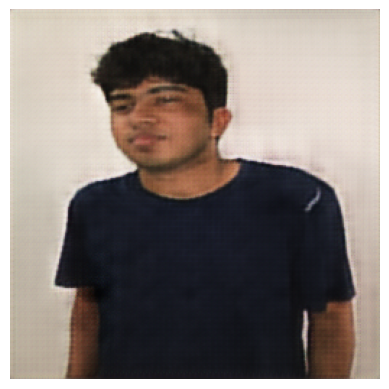

In [63]:
[X1, X2] = dataset
m,n,l = X1[0].shape
print(X1.shape)
# select random example
#ix = randint(0, len(X1), 1)
for i in range(0,len(X1),1):
    print(X1[i].shape)
    print(i)
    src_image, tar_image = X1[i], X2[i]
    src_image = np.reshape(src_image,(1,m,n,l));
    print(src_image.shape)
    # generate image from source
    gen_image = model.predict(src_image)

    # plot all three images
    #plot_images(src_image, gen_image, tar_image)

    gen_image = gen_image[0,:,:,:]
    gen_image = (gen_image + 1)/2
    plt.axis('off')
    plt.imshow(gen_image)
    plt.savefig('C:/Users/archi/Desktop/Images/Output/Output_'+str(i)+'.png', bbox_inches='tight', pad_inches=0)